# Koopman kernel models for TC Tracks

## Tropical cyclone dataset (1970 - 2020)

In this notebook we focus on the Nynstroem kernel and analyze the training results for a larger dataset and various choices of hyperparameter.

In [31]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from kooplearn.models import Kernel, NystroemKernel
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split

from klearn_tcyclone.climada.tc_tracks import TCTracks
from klearn_tcyclone.data_utils import (
    TCTracks_from_TensorContextDataset,
)
from klearn_tcyclone.klearn_tcyclone import ModelBenchmark
from klearn_tcyclone.KNF.modules.eval_metrics import (
    RMSE_OneStep_TCTracks,
)
from klearn_tcyclone.models_utils import predict_time_series
from klearn_tcyclone.performance_benchmark import timer

from klearn_tcyclone.training_utils.training_utils import (
    extend_by_default_flag_values,
)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import product

from klearn_tcyclone.climada.tc_tracks_tools import BASINS_SELECTION

In [34]:
import pandas as pd
import os

In [35]:
current_file_dir_path = os.getcwd()
path_training_results = os.path.join(
    current_file_dir_path,
    "../train_models/",
    "training_results",
)

model_str = "Nystroem_RRR"

flag_params = {
    "koopman_kernel_num_train_stops": 10,
    "year_range": [1980, 2021],
    "model": model_str,
    "koopman_kernel_length_scale": 10.0,
    "koopman_kernel_rank": 50,
    "koopman_kernel_num_centers": 800,
}
flag_params = extend_by_default_flag_values(flag_params)

In [36]:
keys = ["context_length", "koopman_kernel_rank", "train_steps"]

In [37]:
# # basin = BASINS_SELECTION[1]
# # print(basin)
# for basin in BASINS_SELECTION:
#     print(basin)
#     flag_params["basin"] = basin

#     import_dir = os.path.join(
#         path_training_results,
#         "{}_yrange{}_basin{}".format(
#             flag_params["dataset"],
#             "".join(map(str, flag_params["year_range"])),
#             flag_params["basin"],
#         ),
#         flag_params["model"],
#     )

#     file_list = glob.glob(os.path.join(import_dir, "*.pth"))
#     # file_list = glob.glob(os.path.join(import_dir, "*train_steps*.pth"))
#     for file_name in file_list:
#         index = file_name.find("kktstep1.0")
#         if index != -1:
#             start_index = file_name.find("kktstep1.0")
#             new_file_name = file_name[:start_index+7] + "h" + file_name[start_index+7:]
#             # print()
#             # print(file_name)
#             # print(new_file_name)
#             os.rename(file_name, new_file_name)

In [38]:
# file_list = glob.glob(os.path.join(import_dir, "*best*.pth"))
# for file_name in file_list:
#     index = file_name.find("kktsteph")
#     if index == -1:
#         print()
#         start_index = file_name.find("best")
#         new_file_name = file_name[:start_index] + "kktstep1.0_" + file_name[start_index:]
#         os.rename(file_name, new_file_name)

In [48]:
def get_parameters_from_files(folder_path: str, keys: list[str]):
    file_list = glob.glob(os.path.join(folder_path, "*train_steps*.pth"))

    index_identifier = {
        "train_steps": ("train_steps", "_results.pth"),
        "koopman_kernel_rank": ("kkrank", "_kkrdrank"),
        "context_length": ("kkcntlength", "_kktsteph"),
    }

    param_dict = {}
    for key in keys:
        param_dict[key] = []
    # for key in keys:
    #     start_pattern, stop_pattern = index_identifier[key]
    #     param_list = []

    for file_name in file_list:
        for key in keys:
            start_pattern, stop_pattern = index_identifier[key]
            index_start = file_name.find(start_pattern)
            index_end = file_name.find(stop_pattern)
            param_dict[key].append(int(file_name[index_start+len(start_pattern):index_end]))
    
    df_params = pd.DataFrame()
    for key in keys:
        df_params[key] = param_dict[key]

    return df_params

def load_model_results(flag_params: dict, path_training_results: str, keys: list[str]):
    import_dir = os.path.join(
        path_training_results,
        "{}_yrange{}_basin{}".format(
            flag_params["dataset"],
            "".join(map(str, flag_params["year_range"])),
            flag_params["basin"],
        ),
        flag_params["model"],
    )
    model_name = "seed{}_kklnscale{}_kkrank{}_kkrdrank{}_kktkreg{}_kkncntr{}_kkntstops{}_kkcntlength{}_kktsteph{}".format(  # noqa: E501
        flag_params["seed"],
        flag_params["koopman_kernel_length_scale"],
        flag_params["koopman_kernel_rank"],
        flag_params["koopman_kernel_reduced_rank"],
        flag_params["tikhonov_reg"],
        flag_params["koopman_kernel_num_centers"],
        flag_params["koopman_kernel_num_train_stops"],
        flag_params["context_length"],
        flag_params["time_step_h"],
    )
    
    results_file_name = os.path.join(import_dir, model_name)
    df = get_parameters_from_files(import_dir, keys)
    for key in [key for key in keys if key != "train_steps"]:
        df = df[df[key] == flag_params[key]]
    train_steps = df.sort_values(by="train_steps")["train_steps"].to_list()

    load_keys = ["scaler", "eval_rmse", "train_stop", "fit_time"]
    results = {}
    for step in train_steps:
        res= torch.load(
            results_file_name + f"_train_steps{step}_results.pth"
        )
        results[step] = {}
        for key in load_keys:
            results[step][key] = res[key]

    return results

def load_model(flag_params: dict, path_training_results: str):
    import_dir = os.path.join(
        path_training_results,
        "{}_yrange{}_basin{}".format(
            flag_params["dataset"],
            "".join(map(str, flag_params["year_range"])),
            flag_params["basin"],
        ),
        flag_params["model"],
    )
    model_name = "seed{}_kklnscale{}_kkrank{}_kkrdrank{}_kktkreg{}_kkncntr{}_kkntstops{}_kkcntlength{}_kktsteph{}".format(  # noqa: E501
        flag_params["seed"],
        flag_params["koopman_kernel_length_scale"],
        flag_params["koopman_kernel_rank"],
        flag_params["koopman_kernel_reduced_rank"],
        flag_params["tikhonov_reg"],
        flag_params["koopman_kernel_num_centers"],
        flag_params["koopman_kernel_num_train_stops"],
        flag_params["context_length"],
        flag_params["time_step_h"],
    )

    results_file_name = os.path.join(import_dir, model_name)
    best_model_dict = torch.load(
        results_file_name + f"_best_model.pth"
    )
    best_results_dict = torch.load(
        results_file_name + f"_best_results.pth"
    )

    return best_model_dict, best_results_dict

In [49]:
keys = ["context_length", "koopman_kernel_rank", "train_steps"]

In [50]:
current_file_dir_path = os.getcwd()
path_training_results = os.path.join(
    current_file_dir_path,
    "../train_models/",
    "training_results",
)

model_str = "Nystroem_RRR"
# train_stops = [316, 480, 730, 1110, 1687, 2564, 3897, 5923, 9002, 13682]

In [51]:
BASINS_SELECTION

['EP', 'NA', 'SI', 'SP', 'WP']

In [54]:
results = {}
for koopman_kernel_rank in [50, 100, 150]:
    flag_params = {
        "koopman_kernel_num_train_stops": 10,
        "year_range": [1980, 2021],
        "model": model_str,
        "koopman_kernel_length_scale": 10.0,
        "koopman_kernel_rank": koopman_kernel_rank,
        "koopman_kernel_num_centers": 800,
        "context_length": 42
    }
    flag_params = extend_by_default_flag_values(flag_params)
    results[koopman_kernel_rank] = {}
    for basin in BASINS_SELECTION:
        flag_params["basin"] = basin
        results[koopman_kernel_rank][basin] = load_model_results(flag_params, path_training_results, keys)

C:\Users\Eric\AppData\Local\Temp\ipykernel_18888\3693083313.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res= torch.load(
C:\Users\Eric\AppData\Local\Temp\ipykernel_

Set some specific parameters, such as the Koopman kernel model, and load default values for all other parameters.

## Analyze training results

In the following we will focus on the Nystroem_RRR kernel and compare test RMSE values for various hyperparameter configurations.

We consider the kernel length scale, the kernel rank and the number of centers of the Nystroem kernel.

The model training and test RMSE evaluation is done in `train_models/`. Below, the considered hyperparameter values are given, `train_stops` contains a list stopping points for the trainig, i.e. the number of training data points used for model training. 

We first import the model training results.

Below we fix the kernel length scale to the best performing value (see plot below as well) of `length_scale = 10`. The three panels show the three considered kernel rank values, the colors indicate different values for the number of centers, as specified in the legend.

We observe that the number of centers only has a marginal effect. Larger kernel ranks lead to smaller RMSE, but there is not a huge difference between `kernel_rank=25` and `kernel_rank = 45` for the considered dataset.

In [55]:
results.keys()

dict_keys([50, 100, 150])

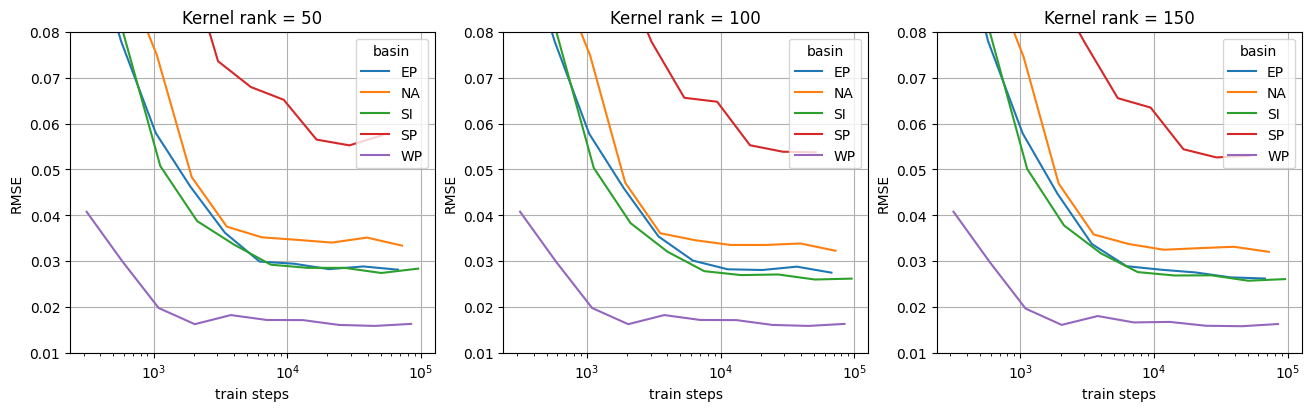

In [45]:
fig, ax = plt.subplots(1,3, layout="constrained")
fig.set_size_inches(13,4)


for idx_kkrank, koopman_kernel_rank in enumerate([50, 100, 150]):

    for idx, basin in enumerate(results[koopman_kernel_rank].keys()):

        train_steps = list(results[koopman_kernel_rank][basin].keys())
        rmse = [results[koopman_kernel_rank][basin][step]["eval_rmse"] for step in train_steps]

        ax[idx_kkrank].plot(train_steps, rmse, color = f"C{idx}", label=basin)
    ax[idx_kkrank].set_xscale("log")
    # ax[idx_kkrank].set_yscale("log")
    ax[idx_kkrank].set_xlabel("train steps")
    ax[idx_kkrank].set_ylabel("RMSE")
    ax[idx_kkrank].set_ylim(0.010, 0.08)
    ax[idx_kkrank].grid()
    ax[idx_kkrank].legend(title="basin")
    ax[idx_kkrank].set_title(f"Kernel rank = {koopman_kernel_rank}")

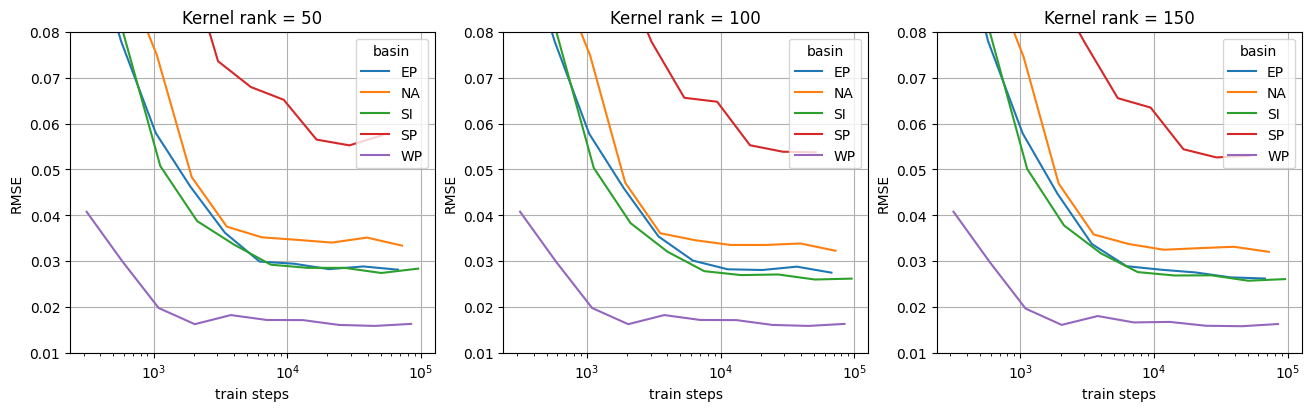

In [56]:
fig, ax = plt.subplots(1,3, layout="constrained")
fig.set_size_inches(13,4)


for idx_kkrank, koopman_kernel_rank in enumerate([50, 100, 150]):

    for idx, basin in enumerate(results[koopman_kernel_rank].keys()):

        train_steps = list(results[koopman_kernel_rank][basin].keys())
        rmse = [results[koopman_kernel_rank][basin][step]["eval_rmse"] for step in train_steps]

        ax[idx_kkrank].plot(train_steps, rmse, color = f"C{idx}", label=basin)
    ax[idx_kkrank].set_xscale("log")
    # ax[idx_kkrank].set_yscale("log")
    ax[idx_kkrank].set_xlabel("train steps")
    ax[idx_kkrank].set_ylabel("RMSE")
    ax[idx_kkrank].set_ylim(0.010, 0.08)
    ax[idx_kkrank].grid()
    ax[idx_kkrank].legend(title="basin")
    ax[idx_kkrank].set_title(f"Kernel rank = {koopman_kernel_rank}")

#### Trajectory prediction

In the following we use the best model to forecast trajectories and wind speed of the tropical cyclone track. We can use the CLIMADA plotting functions to generate nice plots of the predicted tracks.

In [57]:
BASINS_SELECTION

['EP', 'NA', 'SI', 'SP', 'WP']

In [61]:
flag_params = {
    "koopman_kernel_num_train_stops": 10,
    "year_range": [1980, 2021],
    "model": model_str,
    "koopman_kernel_length_scale": 10.0,
    "koopman_kernel_rank": 50,
    "koopman_kernel_num_centers": 800,
    "context_length": 42,
}
flag_params = extend_by_default_flag_values(flag_params)
models = {}
scalers = {}
for basin in BASINS_SELECTION:
    flag_params["basin"] = basin
    best_model_dict, _ = load_model(flag_params, path_training_results)
    models[basin] = best_model_dict["model"]
    scalers[basin] = best_model_dict["scaler"]

C:\Users\Eric\AppData\Local\Temp\ipykernel_18888\3693083313.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_dict = torch.load(
C:\Users\Eric\AppData\Local\Te

In [62]:
basin = BASINS_SELECTION[1]
model = models[basin]
scaler = scalers[basin]
basin

'NA'

We have to import the tropical cyclone data, to test the forecasting capabilities of our trained model.

In [63]:
from klearn_tcyclone.climada.utils import get_TCTrack_dict

In [67]:
feature_list = [
    "lon",
    "lat",
    "max_sustained_wind",
    "radius_max_wind",
    "radius_oci",
    "central_pressure",
    "environmental_pressure",
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device", device)

# Datasets
tc_tracks = get_TCTrack_dict(
    basins=[basin],
    time_step_h=flag_params["time_step_h"],
    year_range=flag_params["year_range"],
)[basin]



# TODO include random_state = seed in train_test_split
tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1, random_state=flag_params["seed"])

Device cuda


c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\xarray\backends\plugins.py:75: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


2024-12-08 13:58:51,363 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2024-12-08 14:00:22,619 - climada.hazard.tc_tracks - WARNING - 57 storm events are discarded because no valid wind/pressure values have been found: 1980199N31284, 1980200N25270, 1980204N23287, 1980226N15339, 1980238N16328, ...


c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:
c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:1511: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "_one_interp_data" failed type inference due to: non-precise type pyobject
During: typing of argument at c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py (1545)

File "..\.venv\Lib\site-packages\climada\hazard\tc_tracks.py", line 1545:
    def _one_interp_data(track, time_step_h, land_geom=None):
        <source elided>

   

We use the benchmark class to normalize the data and to bring the data in the correct shape.

In [68]:
len(tc_tracks_train)

553

In [69]:
len(tc_tracks_test)

62

In [70]:
context_length_test_data = 120

In [71]:
benchmark = ModelBenchmark(
    feature_list,
    tc_tracks_train,
    tc_tracks_test,
    basin=basin,
    # basin="NA",
    scaler=scaler,
    context_length=context_length_test_data,
    # context_length=flag_params["context_length"],
)

benchmark._standardize_data()

contexts = {
    "train": benchmark.tensor_context_train,
    "test": benchmark.tensor_context_test,
}

Data entry 0 has been removed since it is shorter than the 
                    context_length 120 times time_lag 1.
Data entry 5 has been removed since it is shorter than the 
                    context_length 120 times time_lag 1.
Data entry 7 has been removed since it is shorter than the 
                    context_length 120 times time_lag 1.
Data entry 8 has been removed since it is shorter than the 
                    context_length 120 times time_lag 1.
Data entry 11 has been removed since it is shorter than the 
                    context_length 120 times time_lag 1.
Data entry 12 has been removed since it is shorter than the 
                    context_length 120 times time_lag 1.
Data entry 14 has been removed since it is shorter than the 
                    context_length 120 times time_lag 1.
Data entry 17 has been removed since it is shorter than the 
                    context_length 120 times time_lag 1.
Data entry 19 has been removed since it is shorter than the 

Select a random collection of time series in the test context and predict `n_steps = 10` steps into the future.

In [72]:
"""Utils for models."""

from typing import Union

import numpy as np
from kooplearn.data import TensorContextDataset
from kooplearn.models import Kernel, NystroemKernel
from numpy.typing import NDArray

from klearn_tcyclone.performance_benchmark import timer

def predict_context_shift(
    model: Union[Kernel, NystroemKernel], initial_context: TensorContextDataset
) -> TensorContextDataset:
    """Predict the next context windows based on the initial_context_window.

    The predicted context is shifted by one time step to the future.

    Args:
        model (_type_): _description_
        initial_context (TensorContextDataset): _description_

    Returns:
        TensorContextDataset: _description_
    """
    next_step = model.predict(initial_context)
    helper_array = np.concatenate([initial_context.data[:, 1:], next_step], axis=1)
    next_context = TensorContextDataset(helper_array)
    return next_context


def predict_time_series(
    model: Union[Kernel, NystroemKernel],
    initial_context: TensorContextDataset,
    n_steps: int,
    context_length: int,
) -> NDArray:
    """Predict time series based on initial context window.

    Args:
        model (_type_): _description_
        initial_context (TensorContextDataset): _description_
        n_steps (int): _description_

    Returns:
        NDArray: _description_
    """
    time_series_data = []
    current_context = initial_context[:, -context_length:]
    for _ in range(n_steps):
        current_context = predict_context_shift(model, current_context)
        time_series_data.append(current_context.data[:, -1])
    time_series_data = np.array(time_series_data).transpose((1, 0, 2))
    return time_series_data


In [87]:
n_steps_future = 40

In [88]:
idx = np.random.randint(0, contexts["test"].shape[0], 5)
test_context = contexts['test'][idx]

In [89]:
predicted_context = predict_time_series(model, test_context, n_steps=n_steps_future, context_length=flag_params["context_length"])

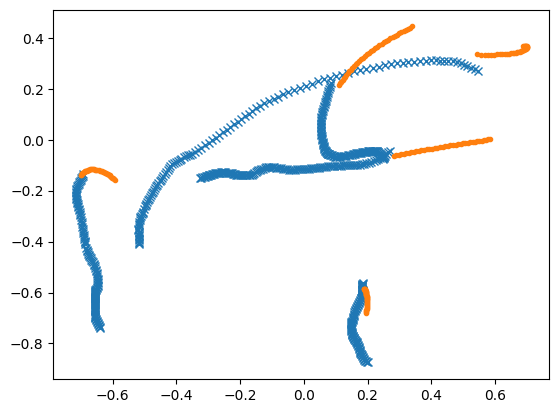

In [90]:
fig, ax = plt.subplots()
_ = ax.plot(test_context.data[:, :, 0], test_context.data[:, :, 1], "x", color="C0")
_ = ax.plot(predicted_context[:, :, 0], predicted_context[:, :, 1], ".", color="C1")

Looks good. To visualize the tropical cyclone tracks and the predictions on the acutal map, we have to scale both back to the original coordinate system.

In [120]:
# #TODO The following generates TensorContextDatasets with smaller context length. This cannot be used as input to prediction for now.
# idx = np.random.randint(0, contexts["train"].shape[0])
# initial_context_arr = contexts['train'].data[:idx,:10]
# print(initial_context_arr.shape)
# print(type(initial_context_arr))
# initial_context = TensorContextDataset(initial_context_arr)
# print(initial_context.shape)
# print(type(initial_context))
# ts = predict_time_series(model, initial_context, n_steps=13)

Predictions are shown as dotted lines. Input test cyclone tracks are shown as solid lines.

In [121]:
test_context_scaled = scaler.inverse_transform(test_context)
predicted_context_scaled = scaler.inverse_transform(predicted_context)

In [122]:
test_context_scaled.shape, predicted_context_scaled.shape

((5, 120, 7), (5, 40, 7))

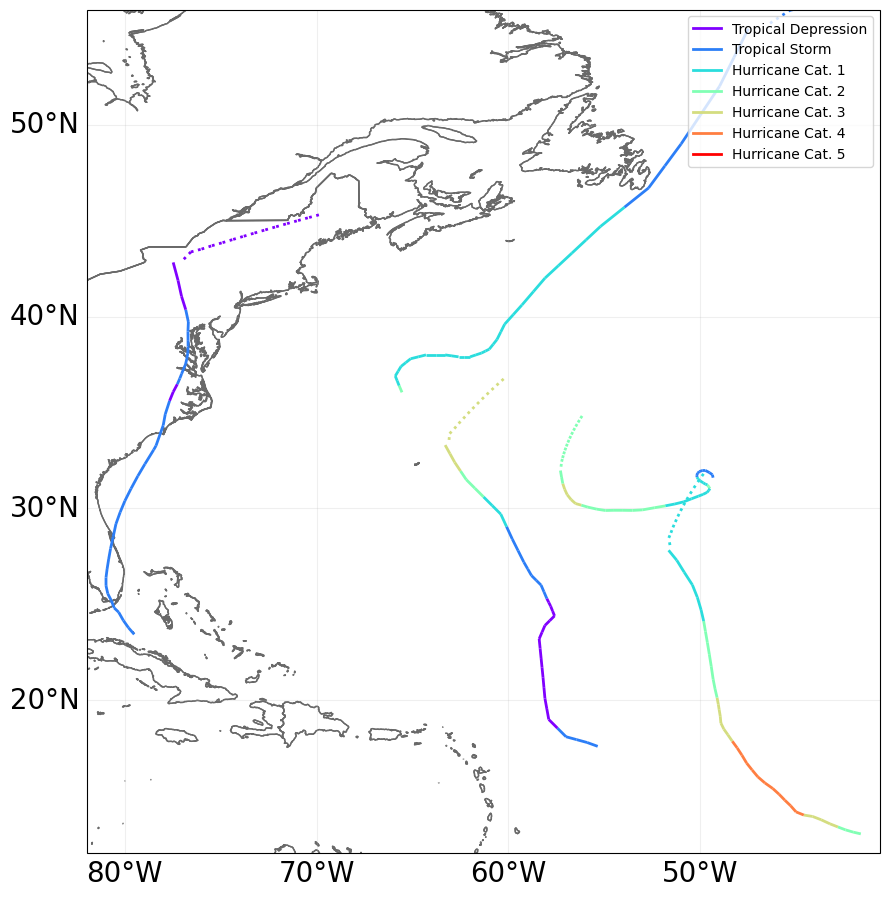

In [123]:
test_context_tc_tracks = TCTracks_from_TensorContextDataset(test_context_scaled[:,::3], feature_list=feature_list)
predicted_context_tc_tracks = TCTracks_from_TensorContextDataset(predicted_context_scaled[:,::3], feature_list=feature_list)

ax = predicted_context_tc_tracks.plot(linestyle="dotted")
_ = test_context_tc_tracks.plot(axis=ax, linestyle="solid")

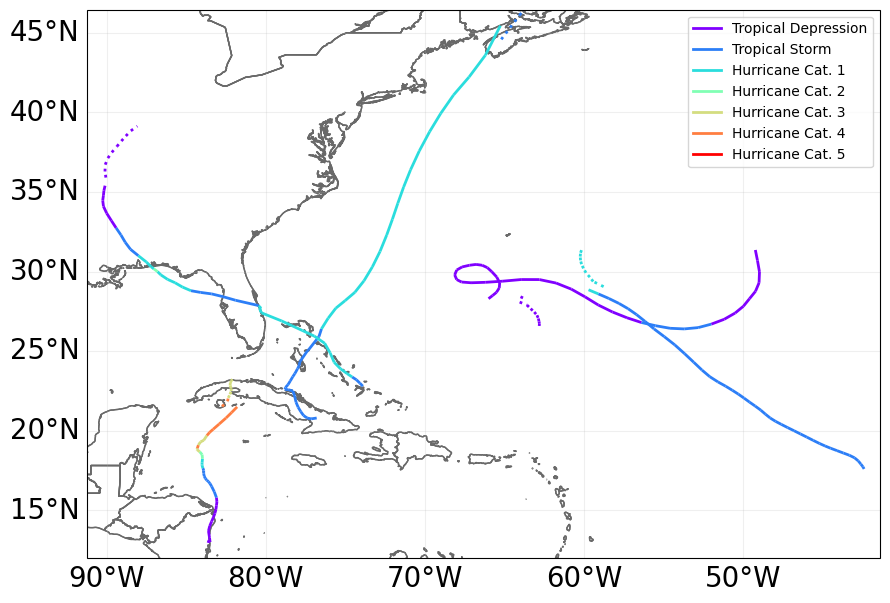

In [ ]:
test_context_scaled = scaler.inverse_transform(test_context)
predicted_context_scaled = scaler.inverse_transform(predicted_context)
test_context_tc_tracks = TCTracks_from_TensorContextDataset(test_context_scaled, feature_list=feature_list)
predicted_context_tc_tracks = TCTracks_from_TensorContextDataset(predicted_context_scaled, feature_list=feature_list)

ax = predicted_context_tc_tracks.plot(linestyle="dotted")
_ = test_context_tc_tracks.plot(axis=ax, linestyle="solid")

This looks reasonably. However, the predictions are still improvable. For example we notice an off-set for the predicted trajectory in relation to the context trajectory.

In the next step, we take a closer look at the context length of the training data and study its influence on the model performance.